In [1]:
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import sklearn.metrics as metrics

sns.set()

**Model Pipeline**

* **1. Reading data** - read sample data
* **2. Cleaning and normalisation** - clean and normalise input data
* **3. Correlations** - calculate and visualise correlations
* **4. Feature importance** - calculate and visualise feature importance
* **5. Model fitting** - fit linear model
* **6. Prediction** - perform out-of-sample prediction


### 1. Read in sales and media spend data

In [2]:
# use sample / synthetic data for now
input_data = 'data/mmm_sample_data.csv'
mmm_df = pd.read_csv(input_data)
mmm_df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


### 2. Clean and normalise input data

In [4]:
mmm_df.drop(['Unnamed: 0'],axis=1, inplace=True)
mmm_df.describe()
# Create week index column
mmm_df['week_index'] = mmm_df.index

In [5]:
# Function to iterate through the synthetic data
def add_week(row):
    start_date = datetime.strptime("2017-01-02","%Y-%m-%d")
    row['date'] = timedelta(row['week_index']*7) + start_date
    return row

# Lambda / closure to replace each row with %Y-%m-%d format start at 2017-01-02 (Monday)
mmm_df = mmm_df.apply(lambda row: add_week(row), axis=1)
mmm_df.drop('week_index', axis=1, inplace=True)

In [6]:
mmm_df

,TV,radio,newspaper,sales,date
0,230.1,37.8,69.2,22.1,2017-01-02
1,44.5,39.3,45.1,10.4,2017-01-09
2,17.2,45.9,69.3,9.3,2017-01-16
3,151.5,41.3,58.5,18.5,2017-01-23
4,180.8,10.8,58.4,12.9,2017-01-30
...,...,...,...,...,...
195,38.2,3.7,13.8,7.6,2020-09-28
196,94.2,4.9,8.1,9.7,2020-10-05
197,177.0,9.3,6.4,12.8,2020-10-12
198,283.6,42.0,66.2,25.5,2020-10-19


In [7]:
# Create input scalers for X variables and output scalers for Y variables
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
mmm_df[['TV', 'radio', 'newspaper']] = input_scaler.fit_transform(mmm_df[['TV', 'radio', 'newspaper']])
mmm_df['sales'] = output_scaler.fit_transform(np.array(mmm_df['sales']).reshape(-1,1))
mmm_df

,TV,radio,newspaper,sales,date
0,0.775786,0.762097,0.605981,0.807087,2017-01-02
1,0.148123,0.792339,0.394019,0.346457,2017-01-09
2,0.055800,0.925403,0.606860,0.303150,2017-01-16
3,0.509976,0.832661,0.511873,0.665354,2017-01-23
4,0.609063,0.217742,0.510994,0.444882,2017-01-30
...,...,...,...,...,...
195,0.126818,0.074597,0.118734,0.236220,2020-09-28
196,0.316199,0.098790,0.068602,0.318898,2020-10-05
197,0.596212,0.187500,0.053650,0.440945,2020-10-12
198,0.956713,0.846774,0.579595,0.940945,2020-10-19


### 3. Calculate and visualise the correlations

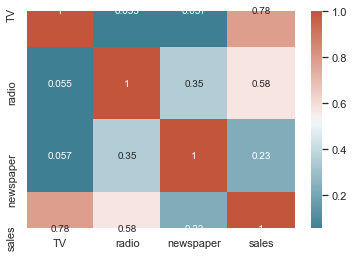

In [8]:
corr = mmm_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

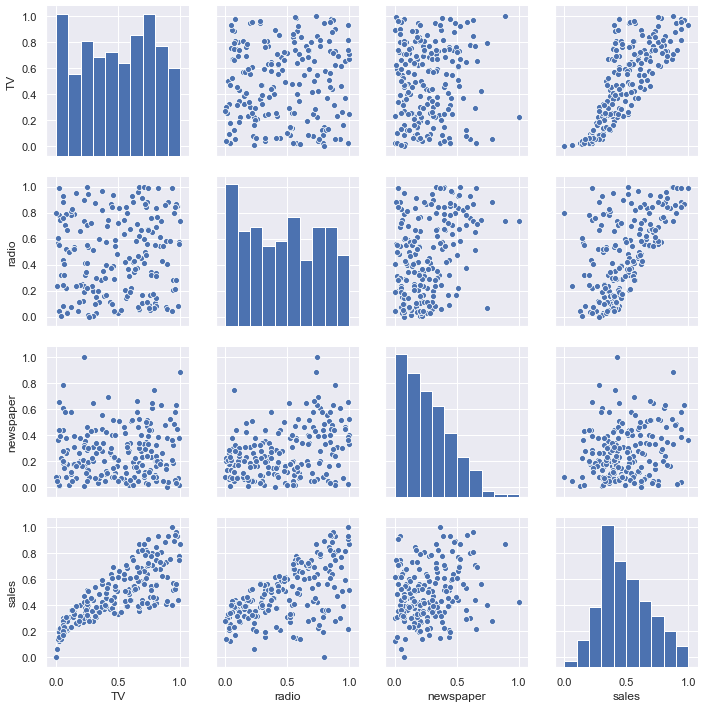

In [9]:
# TV spend has the highest correlation with sales
# Let's also visualise the variable interaction using pair plots 
sns.pairplot(mmm_df)

### 4. Calculate and visualise feature importance

In [10]:
# Setting X and y variables, remove sales from the independent variable set
X = mmm_df.loc[:, (mmm_df.columns != 'sales')&(mmm_df.columns != 'date')]
y = mmm_df['sales']
X_train = X[:int(X.shape[0]*.8)]
X_test = X[int(X.shape[0]*.8):]
y_train = y[:int(X.shape[0]*.8)]
y_test = y[int(X.shape[0]*.8):]

# Use linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 5. Perform Out of Sample Prediction

In [11]:
y_pred = model.predict(X_test)
y_pred = output_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = output_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

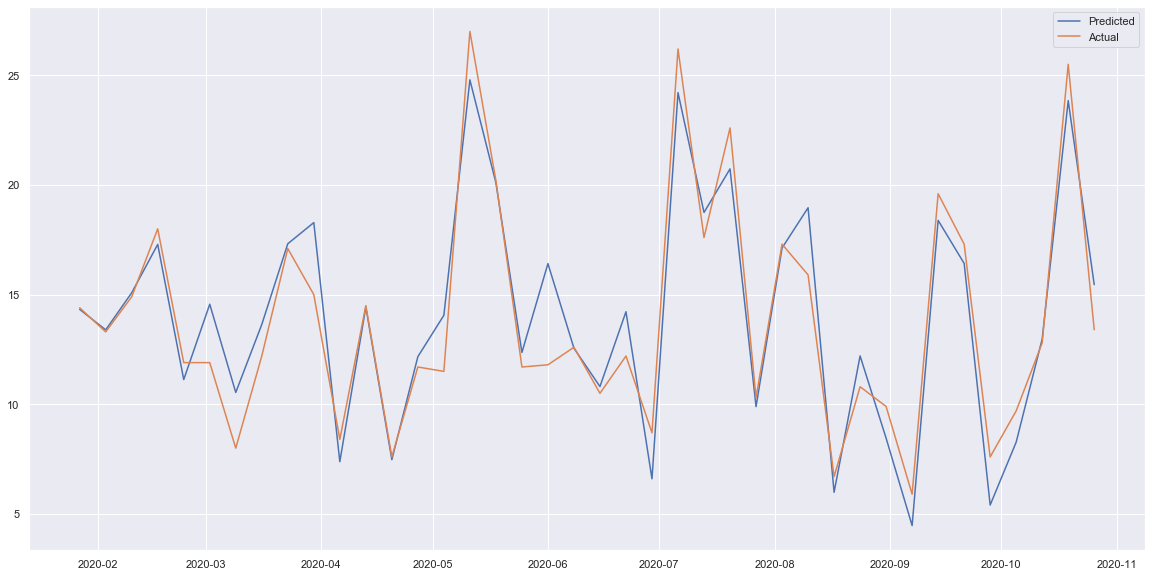

In [13]:
plt.figure(figsize=(20, 10))
# Let's split training / test set at 80 / 20
# Visualise actual vs predicted
plt.plot(mmm_df['date'][int(int(mmm_df.shape[0]*.8)):], y_pred, label = 'Predicted')
plt.plot(mmm_df['date'][int(int(mmm_df.shape[0]*.8)):], y_test, label = 'Actual')
plt.legend()

In [14]:
# Print MSE / mean squared error
metrics.mean_squared_error(y_test, y_pred)

2.791145186276392

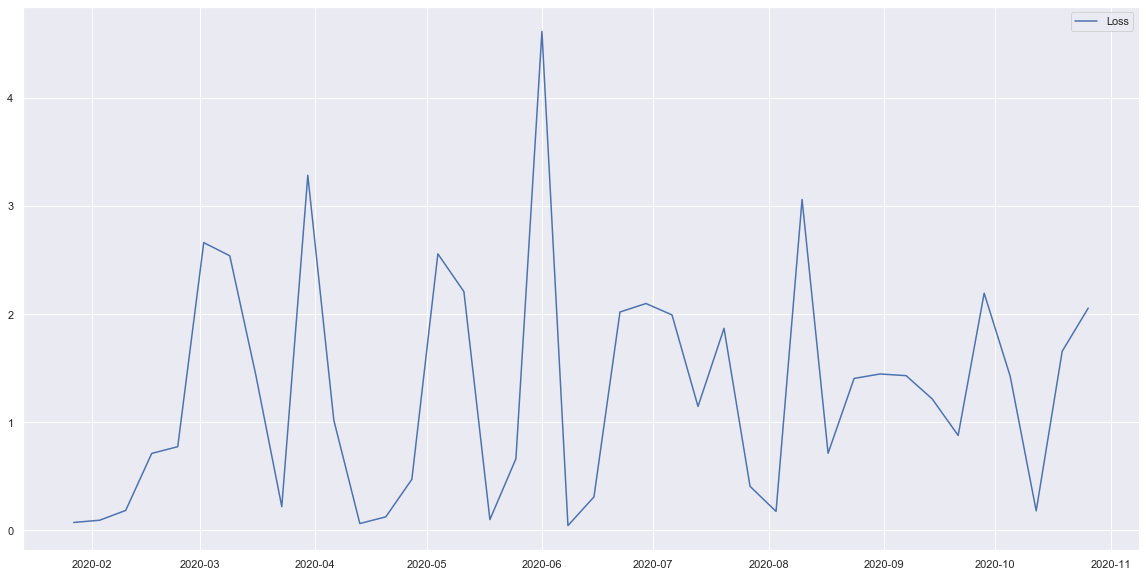

In [15]:
#  Visualise / calculate y_test-y_pred
plt.figure(figsize=(20, 10))
plt.plot(mmm_df['date'][int(int(mmm_df.shape[0]*.8)):], np.sqrt((y_test-y_pred)**2), label = 'Loss')
plt.legend()